In [1]:
# 导入库
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import sklearn.metrics as metrics

In [2]:
# 忽略报错
import warnings
warnings.filterwarnings("ignore")

# 中文
plt.rcParams['font.family'] = ['Arial Unicode MS'] 

# 1. 数据概况

In [3]:
# 导入数据
pdd = pd.read_csv('拼多多优惠券数据.csv')

In [4]:
pdd.head()

,ID,age,job,marital,default,returned,loan,coupon_used_in_last6_month,coupon_used_in_last_month,coupon_ind
0,1,43,management,married,no,yes,no,2,0,0
1,2,42,technician,divorced,no,yes,no,1,1,0
2,3,47,admin.,married,no,yes,yes,2,0,0
3,4,28,management,single,no,yes,yes,2,0,0
4,5,42,technician,divorced,no,yes,no,5,0,0


In [5]:
# 查看字段
pdd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25317 entries, 0 to 25316
Data columns (total 10 columns):
ID                            25317 non-null int64
age                           25317 non-null int64
job                           25317 non-null object
marital                       25317 non-null object
default                       25317 non-null object
returned                      25317 non-null object
loan                          25317 non-null object
coupon_used_in_last6_month    25317 non-null int64
coupon_used_in_last_month     25317 non-null int64
coupon_ind                    25317 non-null int64
dtypes: int64(5), object(5)
memory usage: 1.9+ MB


In [6]:
# 缺失值分析
pd.DataFrame(pdd.isnull().sum()).reset_index().rename(columns={'index':'字段名', 0:'缺失值数量'})

,字段名,缺失值数量
0,ID,0
1,age,0
2,job,0
3,marital,0
4,default,0
5,returned,0
6,loan,0
7,coupon_used_in_last6_month,0
8,coupon_used_in_last_month,0
9,coupon_ind,0


In [7]:
# 数值型变量异常值分析
pdd.describe().drop(['ID', 'coupon_ind'], axis=1)

,age,coupon_used_in_last6_month,coupon_used_in_last_month
count,25317.000000,25317.000000,25317.000000
mean,40.935379,2.772050,0.292847
std,10.634289,3.136097,0.765498
min,18.000000,1.000000,0.000000
25%,33.000000,1.000000,0.000000
50%,39.000000,2.000000,0.000000
75%,48.000000,3.000000,0.000000
max,95.000000,55.000000,15.000000


- age中可能存在离群值
- coupon_used_in_last6_month中可能存在离群值

In [8]:
sum(pdd.duplicated())

0

# 2. 单变量分析

## 2.1 预测目标

In [9]:
# coupon_ind中0和1占比
pdd.coupon_ind.value_counts(1).reset_index().rename(columns={'index':'类别', 'coupon_ind':'占比'}).set_index('类别')

,占比
类别,
0,0.883043
1,0.116957


- 数据集不均衡

## 2.2 数值型变量

In [10]:
pdd.groupby('coupon_ind').mean().drop('ID',axis=1)

,age,coupon_used_in_last6_month,coupon_used_in_last_month
coupon_ind,,,
0,40.819601,2.857846,0.260378
1,41.809524,2.124282,0.537994


- 三个字段在0和1不同类别中均值有差异，但age差异不明显

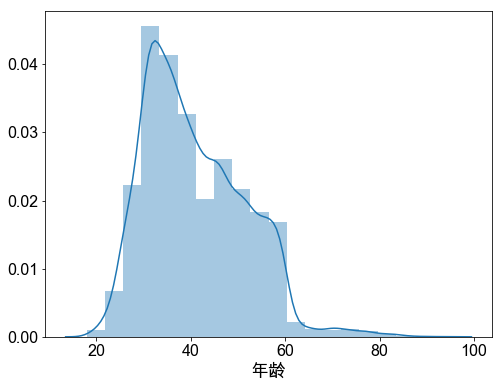

In [11]:
# 用户年龄
plt.figure(figsize=(8,6))
sns.distplot(pdd['age'], bins =20)
plt.tick_params(labelsize=16)
plt.xlabel('年龄', size=18);

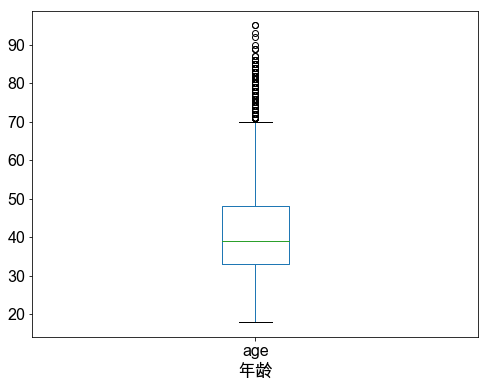

In [12]:
plt.figure(figsize=(8,6))
pdd['age'].plot(kind='box')
plt.tick_params(labelsize=16)
plt.xlabel('年龄', size=18);

- 用户年龄主要集中在50岁以下
- 考虑分箱操作或踢出离群值

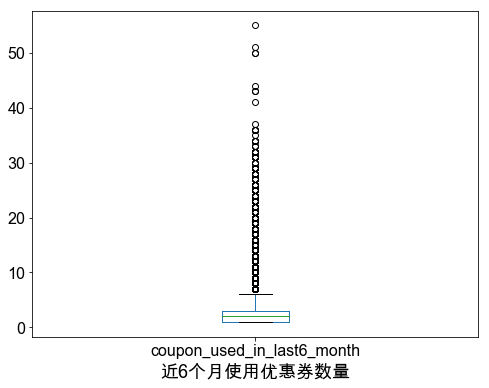

In [13]:
# 用户近6个月使用优惠券数量
plt.figure(figsize=(8,6))
pdd['coupon_used_in_last6_month'].plot(kind='box')
plt.tick_params(labelsize=16)
plt.xlabel('近6个月使用优惠券数量', size=18);

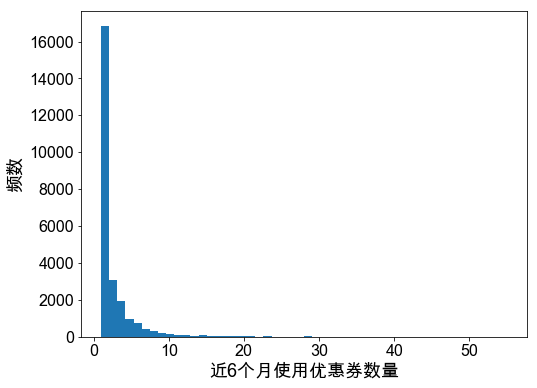

In [14]:
plt.figure(figsize=(8,6))
pdd['coupon_used_in_last6_month'].plot(kind='hist', bins=50)
plt.tick_params(labelsize=16)
plt.xlabel('近6个月使用优惠券数量', size=18);
plt.ylabel('频数', size=18);

- 用户近6个月使用优惠券数量主要集中在10以下
- 考虑分箱操作或剔除离群值

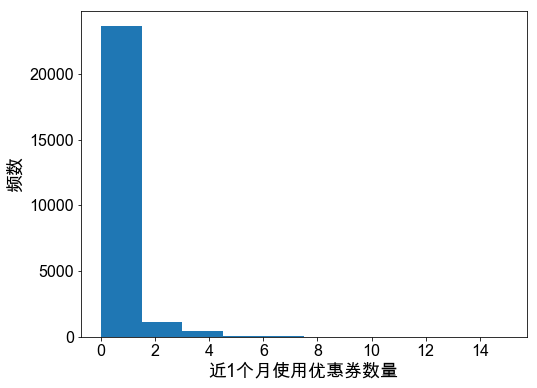

In [15]:
# 用户近1个月使用优惠券数量
plt.figure(figsize=(8,6))
pdd['coupon_used_in_last_month'].plot(kind='hist', bins=10)
plt.tick_params(labelsize=16)
plt.xlabel('近1个月使用优惠券数量', size=18);
plt.ylabel('频数', size=18);

- 用户近1个月使用优惠券数量没什么异常

## 2.3 类别型变量

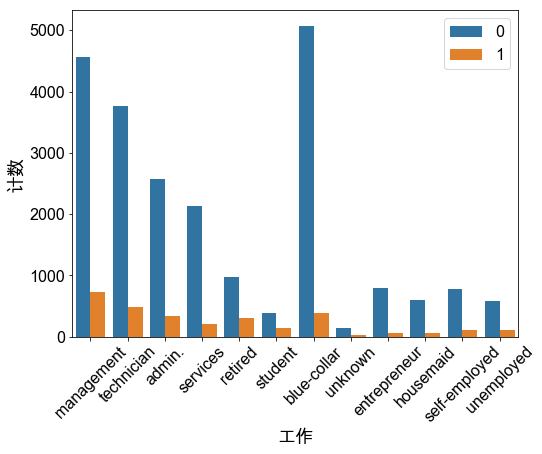

In [16]:
# 用户工作情况
plt.figure(figsize=(8,6))
sns.countplot(x='job', data=pdd, hue='coupon_ind')
plt.xticks(rotation=45)
plt.tick_params(labelsize=16)
plt.xlabel('工作', size=18)
plt.ylabel('计数', size=18)
plt.legend(fontsize=16);

In [17]:
pdd.groupby('coupon_ind')['job'].value_counts(1)

coupon_ind  job          
0           blue-collar      0.226740
            management       0.203972
            technician       0.168188
            admin.           0.114868
            services         0.095321
            retired          0.043612
            entrepreneur     0.035293
            self-employed    0.034845
            housemaid        0.027062
            unemployed       0.026257
            student          0.017445
            unknown          0.006396
1           management       0.248565
            technician       0.162445
            blue-collar      0.130699
            admin.           0.115164
            retired          0.100642
            services         0.071260
            student          0.048294
            unemployed       0.038501
            self-employed    0.035461
            entrepreneur     0.022627
            housemaid        0.019588
            unknown          0.006754
Name: job, dtype: float64

- 0和1间职业分布不同，会使用优惠券的样本中从事管理行业的人居多，而不使用优惠券的人群中蓝领居多

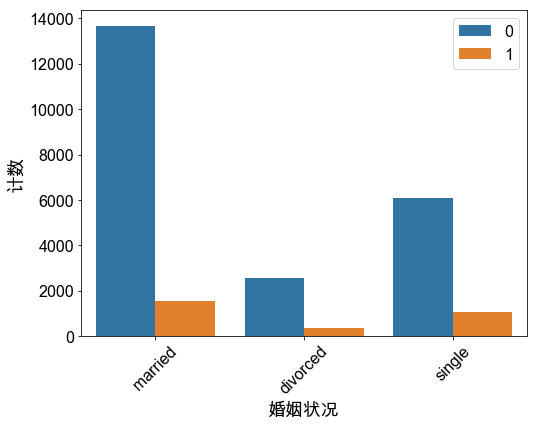

In [18]:
# 用户婚姻状况
plt.figure(figsize=(8,6))
sns.countplot(x='marital', data=pdd, hue='coupon_ind')
plt.xticks(rotation=45)
plt.tick_params(labelsize=16)
plt.xlabel('婚姻状况', size=18)
plt.ylabel('计数', size=18)
plt.legend(fontsize=16);

In [19]:
pdd.groupby('coupon_ind')['marital'].value_counts(1)

coupon_ind  marital 
0           married     0.611916
            single      0.273260
            divorced    0.114824
1           married     0.528538
            single      0.353934
            divorced    0.117528
Name: marital, dtype: float64

- 0和1间各类别占比不同，但差别不大

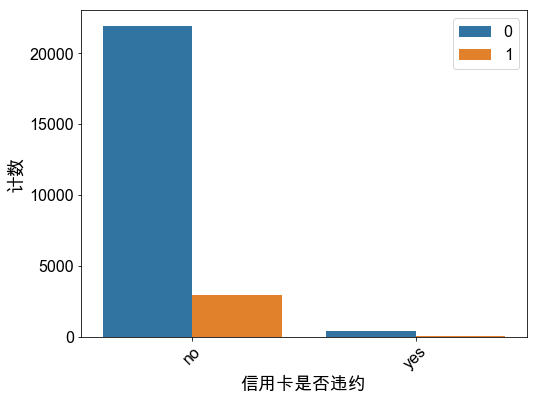

In [20]:
# 用户信用卡违约情况
plt.figure(figsize=(8,6))
sns.countplot(x='default', data=pdd, hue='coupon_ind')
plt.xticks(rotation=45)
plt.tick_params(labelsize=16)
plt.xlabel('信用卡是否违约', size=18)
plt.ylabel('计数', size=18)
plt.legend(fontsize=16);

In [21]:
pdd.groupby('coupon_ind')['default'].value_counts(1)

coupon_ind  default
0           no         0.981124
            yes        0.018876
1           no         0.991219
            yes        0.008781
Name: default, dtype: float64

- 0和1中均是信用卡不违约的人群占绝大多数，几乎无差异

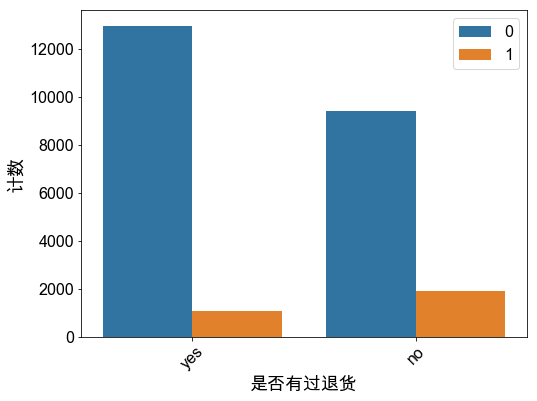

In [22]:
# 用户退货情况
plt.figure(figsize=(8,6))
sns.countplot(x='returned', data=pdd, hue='coupon_ind')
plt.xticks(rotation=45)
plt.tick_params(labelsize=16)
plt.xlabel('是否有过退货', size=18)
plt.ylabel('计数', size=18)
plt.legend(fontsize=16);

In [23]:
pdd.groupby('coupon_ind')['returned'].value_counts(1)

coupon_ind  returned
0           yes         0.579755
            no          0.420245
1           no          0.642351
            yes         0.357649
Name: returned, dtype: float64

- 0中用户多有过退货行为，1中多数用户不退货

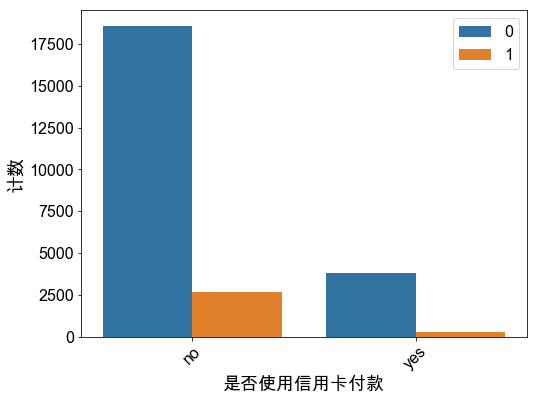

In [24]:
# 用户使用信用卡付款情况
plt.figure(figsize=(8,6))
sns.countplot(x='loan', data=pdd, hue='coupon_ind')
plt.xticks(rotation=45)
plt.tick_params(labelsize=16)
plt.xlabel('是否使用信用卡付款', size=18)
plt.ylabel('计数', size=18)
plt.legend(fontsize=16);

In [25]:
pdd.groupby('coupon_ind')['loan'].value_counts(1)

coupon_ind  loan
0           no      0.830963
            yes     0.169037
1           no      0.905437
            yes     0.094563
Name: loan, dtype: float64

- 0和1中均是使用过信用卡付款的人群占绝大多数，但1中的比例更高

# 3. 数据处理

In [26]:
# 复制数据作备份
pdd_clean = pdd.copy()

In [27]:
# 去掉ID字段
pdd_clean.drop('ID', axis=1, inplace=True)

In [28]:
# 将coupon_ind更名为flag
pdd_clean = pdd_clean.rename(columns={'coupon_ind':'flag'})

In [29]:
# 将年龄分段
bins = [0, 25, 45, 65, 100]
labels = ['<25', '25-45', '45-65', '>65']
pdd_clean['age_range'] = pd.cut(pdd_clean['age'], bins, right=False, labels = labels)

In [30]:
# 将用户近6个月使用优惠券数量分段
bins = [0, 10, 100]
labels = ['<10', '>=10']
pdd_clean['coupon_last6_range'] = pd.cut(pdd_clean['coupon_used_in_last6_month'], bins, right=False, labels = labels)

In [31]:
# 将类别变量转换成哑变量，并去掉冗余字段
pdd_clean = pd.get_dummies(pdd_clean, drop_first=True)

In [32]:
pdd_clean.head()

,age,coupon_used_in_last6_month,coupon_used_in_last_month,flag,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,job_unknown,marital_married,marital_single,default_yes,returned_yes,loan_yes,age_range_25-45,age_range_45-65,age_range_>65,coupon_last6_range_>=10
0,43,2,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,1,0,0,0
1,42,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,47,2,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,0,1,0,0
3,28,2,0,0,0,0,0,1,0,0,...,0,0,1,0,1,1,1,0,0,0
4,42,5,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


# 4. 多变量分析

In [33]:
# 相关性系数计算
pdd_clean.corr()[['flag']].sort_values('flag', ascending=False)

,flag
flag,1.000000
age_range_>65,0.130724
coupon_used_in_last_month,0.116550
job_retired,0.083868
job_student,0.069058
marital_single,0.057574
job_management,0.035234
age,0.029916
job_unemployed,0.023980
job_unknown,0.001438


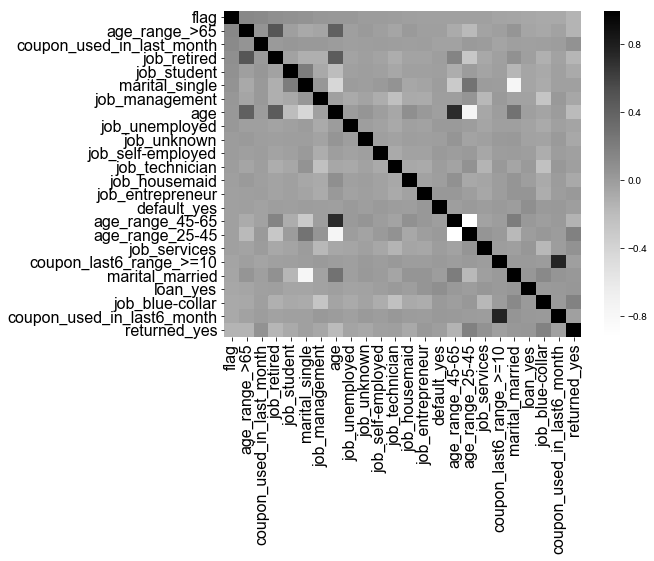

In [34]:
plt.figure(figsize=(8,6))
sns.heatmap(pdd_clean[pdd_clean.corr()[['flag']].sort_values('flag', ascending=False).index].corr(), cmap="Greys")
plt.tick_params(labelsize=16)

- 变量age_range_>65、coupon_used_in_last_month、job_retired、job_student、matital_single与flag较强烈正相关
- 变量marital_married、loan_yes、job_blue-collar、coupon_used_in_last6_month、returned_yes与flag呈现较强负相关性

# 5. 逻辑回归模型建立

In [93]:
# 保存每个方案的precision, recal, f1, AUC，方便后续优化可视化
names = list()
scores_train = list()
scores_test = list()
precisions = list()
recalls = list()
f1 = list()
auc = list()

In [36]:
# 定义自变量，提取相关性系数大于±0.05的变量
threshold = 0.05
tmp = pdd_clean.corr()[['flag']].sort_values('flag', ascending=False)
var = tmp.where(np.abs(tmp)>threshold).dropna(how='any').index.values
var = var[1:]
X = pdd_clean[var]
y = pdd_clean['flag']

print(var)

['age_range_>65' 'coupon_used_in_last_month' 'job_retired' 'job_student'
 'marital_single' 'marital_married' 'loan_yes' 'job_blue-collar'
 'coupon_used_in_last6_month' 'returned_yes']


In [37]:
X.head()

,age_range_>65,coupon_used_in_last_month,job_retired,job_student,marital_single,marital_married,loan_yes,job_blue-collar,coupon_used_in_last6_month,returned_yes
0,0,0,0,0,0,1,0,0,2,1
1,0,1,0,0,0,0,0,0,1,1
2,0,0,0,0,0,1,1,0,2,1
3,0,0,0,0,1,0,1,0,2,1
4,0,0,0,0,0,0,0,0,5,1


In [94]:
# ROC/AUC评估
def plot_roc_curve_auc(model, X_test, y_test):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.decision_function(X_test), pos_label=1)
    plt.step(fpr, tpr, where='post', color='b')
    plt.fill_between(fpr, tpr, step= 'post', color='b', alpha=0.2)
    plt.ylim([0, 1.05])
    plt.show()
    print("AUC=%.4f"%metrics.auc(fpr, tpr))

# 模型评估
def evaluation_model(model, X_train, y_train, X_test, y_test):
    print("训练集打分：%.4f\n测试集打分：%.4f" % (model.score(X_train, y_train), model.score(X_test, y_test)))

    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=['flag=0', 'flag=1']))
    return y_pred

def work(X, y, type):
    # 分割数据集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)
    # 训练模型
    model = LogisticRegression()
    model.fit(X_train, y_train)
    # 模型评估
    print(type)
    print("\n")
    y_pred = evaluation_model(model, X_train, y_train, X_test, y_test)

    # ROC/AUC评估
    plot_roc_curve_auc(model, X_test, y_test)

    return model, X_train, X_test, y_train, y_test, y_pred

原始模型


训练集打分：0.8813
测试集打分：0.8859
              precision    recall  f1-score   support

      flag=0       0.89      1.00      0.94      6733
      flag=1       0.45      0.02      0.04       863

    accuracy                           0.89      7596
   macro avg       0.67      0.51      0.49      7596
weighted avg       0.84      0.89      0.84      7596



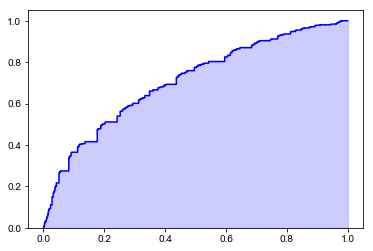

AUC=0.7139
参数 age_range_>65 : 1.069  概率比值 2.912
参数 coupon_used_in_last_month : 0.409  概率比值 1.505
参数 job_retired : 0.221  概率比值 1.247
参数 job_student : 0.461  概率比值 1.585
参数 marital_single : 0.262  概率比值 1.300
参数 marital_married : -0.001  概率比值 0.999
参数 loan_yes : -0.471  概率比值 0.624
参数 job_blue-collar : -0.300  概率比值 0.741
参数 coupon_used_in_last6_month : -0.154  概率比值 0.858
参数 returned_yes : -0.835  概率比值 0.434
参数 intercept : -1.437  概率比值 0.238


In [97]:
# 原始模型
LR, X_train, X_test, y_train, y_test, y_pred = work(X, y, "原始模型")

# 模型参数
for a, b in zip(np.append(var, 'intercept'), np.append(LR.coef_, LR.intercept_)):
    print("参数 %s : %.3f  概率比值 %.3f" % (a, b, np.exp(b)))


# 保存数据
names.append('initial')
scores_train.append(LR.score(X_train, y_train))
scores_test.append(LR.score(X_test, y_test))
precisions.append(metrics.precision_score(y_test, y_pred)) #只看flag=1
recalls.append(metrics.recall_score(y_test, y_pred)) #只看flag=1
f1.append(metrics.f1_score(y_test, y_pred)) #只看flag=1
auc.append(metrics.auc(fpr, tpr))

- AUC分数 还可以
- flag=1召回率极低
- 需要考虑数据不均衡性

# 6. 模型优化

增加测试集的比例：


训练集打分：0.8839
测试集打分：0.8802
              precision    recall  f1-score   support

      flag=0       0.88      1.00      0.94     11162
      flag=1       0.38      0.02      0.04      1497

    accuracy                           0.88     12659
   macro avg       0.63      0.51      0.49     12659
weighted avg       0.82      0.88      0.83     12659



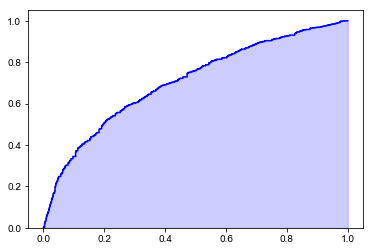

AUC=0.7078


In [69]:
# 1. 增加测试集的比例
# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 100)

# 训练模型
LR = LogisticRegression()
LR.fit(X_train, y_train)

# 模型评估
print("增加测试集的比例：")
print("\n")
y_pred = evaluation_model(LR, X_train, y_train, X_test, y_test)

# ROC/AUC评估
plot_roc_curve_auc(LR, X_test, y_test)

# 保存数据
names.append('+ test_size')
scores_train.append(LR.score(X_train, y_train))
scores_test.append(LR.score(X_test, y_test))
precisions.append(metrics.precision_score(y_test, y_pred)) #只看flag=1
recalls.append(metrics.recall_score(y_test, y_pred)) #只看flag=1
f1.append(metrics.f1_score(y_test, y_pred)) #只看flag=1
auc.append(metrics.auc(fpr, tpr))

- 增加测试集比例，反而打分下降，舍弃

改变自变量（threshold=0.01）：


训练集打分：0.8808
测试集打分：0.8855
              precision    recall  f1-score   support

      flag=0       0.89      1.00      0.94      6733
      flag=1       0.42      0.02      0.04       863

    accuracy                           0.89      7596
   macro avg       0.65      0.51      0.49      7596
weighted avg       0.83      0.89      0.84      7596



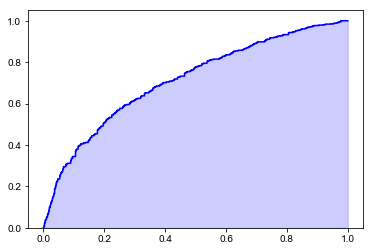

AUC=0.7141


In [70]:
# 2. 改变自变量

# 2.1 定义自变量，提取相关性系数大于±0.01的变量
threshold = 0.01
tmp = pdd_clean.corr()[['flag']].sort_values('flag', ascending=False)
var = tmp.where(np.abs(tmp)>threshold).dropna(how='any').index.values
var = var[1:]
X = pdd_clean[var].drop(['age', 'coupon_last6_range_>=10'], axis=1)
y = pdd_clean['flag']


LR, X_train, X_test, y_train, y_test, y_pred = work(X, y, "改变自变量")


# 保存数据
names.append('+ X1')
scores_train.append(LR.score(X_train, y_train))
scores_test.append(LR.score(X_test, y_test))
precisions.append(metrics.precision_score(y_test, y_pred)) #只看flag=1
recalls.append(metrics.recall_score(y_test, y_pred)) #只看flag=1
f1.append(metrics.f1_score(y_test, y_pred)) #只看flag=1
auc.append(metrics.auc(fpr, tpr))

- 扩大自变量范围，没什么变化

改变自变量（all）：


训练集打分：0.8809
测试集打分：0.8855
              precision    recall  f1-score   support

      flag=0       0.89      1.00      0.94      6733
      flag=1       0.42      0.02      0.04       863

    accuracy                           0.89      7596
   macro avg       0.65      0.51      0.49      7596
weighted avg       0.83      0.89      0.84      7596



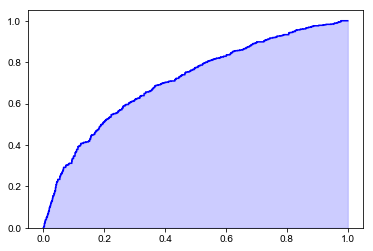

AUC=0.7140


In [71]:
# 2.2 放入全部变量

X = pdd_clean.drop(['flag', 'age', 'coupon_last6_range_>=10'], axis=1)
y = pdd_clean['flag']


LR, X_train, X_test, y_train, y_test, y_pred = work(X, y, "放入全部变量")



# 保存数据
names.append('+ X2')
scores_train.append(LR.score(X_train, y_train))
scores_test.append(LR.score(X_test, y_test))
precisions.append(metrics.precision_score(y_test, y_pred)) #只看flag=1
recalls.append(metrics.recall_score(y_test, y_pred)) #只看flag=1
f1.append(metrics.f1_score(y_test, y_pred)) #只看flag=1
auc.append(metrics.auc(fpr, tpr))

- 放入全部变量，打分略有下降

数据标准化：


训练集打分：0.8813
测试集打分：0.8859
              precision    recall  f1-score   support

      flag=0       0.89      1.00      0.94      6733
      flag=1       0.45      0.02      0.04       863

    accuracy                           0.89      7596
   macro avg       0.67      0.51      0.49      7596
weighted avg       0.84      0.89      0.84      7596



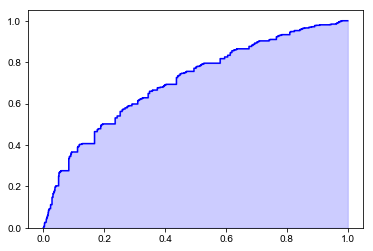

AUC=0.7134


In [72]:
# 3. 数据标准化

# 定义自变量，提取相关性系数大于±0.05的变量
threshold = 0.05
tmp = pdd_clean.corr()[['flag']].sort_values('flag', ascending=False)
var = tmp.where(np.abs(tmp)>threshold).dropna(how='any').index.values
var = var[1:]
X = pdd_clean[var]
y = pdd_clean['flag']

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

# 训练模型
LR = LogisticRegression()
LR.fit(X_train, y_train)

# 模型评估
print("数据标准化：")
print("\n")
y_pred = evaluation_model(LR, X_train, y_train, X_test, y_test)

# ROC/AUC评估
plot_roc_curve_auc(LR, X_test, y_test)

# 保存数据
names.append('+ standalization')
scores_train.append(LR.score(X_train, y_train))
scores_test.append(LR.score(X_test, y_test))
precisions.append(metrics.precision_score(y_test, y_pred)) #只看flag=1
recalls.append(metrics.recall_score(y_test, y_pred)) #只看flag=1
f1.append(metrics.f1_score(y_test, y_pred)) #只看flag=1
auc.append(metrics.auc(fpr, tpr))

- flag=1 精确度有小幅提高

SMOTE算法：


训练集打分：0.6471
测试集打分：0.6583
              precision    recall  f1-score   support

      flag=0       0.65      0.69      0.67      6689
      flag=1       0.67      0.63      0.65      6725

    accuracy                           0.66     13414
   macro avg       0.66      0.66      0.66     13414
weighted avg       0.66      0.66      0.66     13414



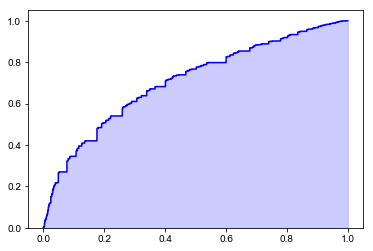

AUC=0.7139


In [73]:
# 4.1 SMOTE算法（上采样）

# 定义自变量，提取相关性系数大于±0.05的变量
threshold = 0.05
tmp = pdd_clean.corr()[['flag']].sort_values('flag', ascending=False)
var = tmp.where(np.abs(tmp)>threshold).dropna(how='any').index.values
var = var[1:]
X = pdd_clean[var]
y = pdd_clean['flag']

# SMOTE算法
from imblearn.over_sampling import SMOTE
smo = SMOTE(random_state=100) 
X_smo, y_smo = smo.fit_sample(X, y)


LR, X_train, X_test, y_train, y_test, y_pred = work(X_smo, y_smo, "SMOTE算法")

# 保存数据
names.append('+ SMOTE')
scores_train.append(LR.score(X_train, y_train))
scores_test.append(LR.score(X_test, y_test))
precisions.append(metrics.precision_score(y_test, y_pred)) #只看flag=1
recalls.append(metrics.recall_score(y_test, y_pred)) #只看flag=1
f1.append(metrics.f1_score(y_test, y_pred)) #只看flag=1
auc.append(metrics.auc(fpr, tpr))

RandomOverSampler算法：


训练集打分：0.6487
测试集打分：0.6501
              precision    recall  f1-score   support

      flag=0       0.64      0.68      0.66      6689
      flag=1       0.66      0.62      0.64      6725

    accuracy                           0.65     13414
   macro avg       0.65      0.65      0.65     13414
weighted avg       0.65      0.65      0.65     13414



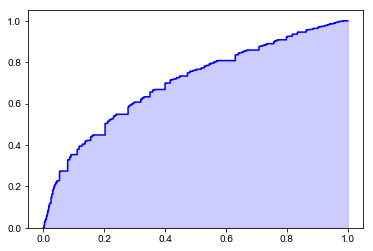

AUC=0.7068


In [74]:
# 4.2 RandomOverSampler（上采样）

# 定义自变量，提取相关性系数大于±0.05的变量
threshold = 0.05
tmp = pdd_clean.corr()[['flag']].sort_values('flag', ascending=False)
var = tmp.where(np.abs(tmp)>threshold).dropna(how='any').index.values
var = var[1:]
X = pdd_clean[var]
y = pdd_clean['flag']

# RandomOverSampler算法
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=100) 
X_ros, y_ros = ros.fit_sample(X, y)

LR, X_train, X_test, y_train, y_test, y_pred = work(X_ros, y_ros, "RandomOverSampler算法")

# 保存数据
names.append('+ RandomOverSampler')
scores_train.append(LR.score(X_train, y_train))
scores_test.append(LR.score(X_test, y_test))
precisions.append(metrics.precision_score(y_test, y_pred)) #只看flag=1
recalls.append(metrics.recall_score(y_test, y_pred)) #只看flag=1
f1.append(metrics.f1_score(y_test, y_pred)) #只看flag=1
auc.append(metrics.auc(fpr, tpr))

RandomUnderSampler：


训练集打分：0.6495
测试集打分：0.6320
              precision    recall  f1-score   support

      flag=0       0.64      0.63      0.64       906
      flag=1       0.62      0.63      0.63       871

    accuracy                           0.63      1777
   macro avg       0.63      0.63      0.63      1777
weighted avg       0.63      0.63      0.63      1777



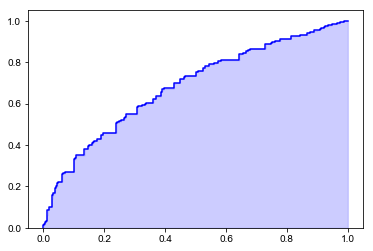

AUC=0.6894


In [75]:
# 4.3 RandomUnderSampler算法（下采样）

# 定义自变量，提取相关性系数大于±0.05的变量
threshold = 0.05
tmp = pdd_clean.corr()[['flag']].sort_values('flag', ascending=False)
var = tmp.where(np.abs(tmp)>threshold).dropna(how='any').index.values
var = var[1:]
X = pdd_clean[var]
y = pdd_clean['flag']

# RandomUnderSampler算法
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state = 100)
X_rus, y_rus = rus.fit_sample(X, y)

LR, X_train, X_test, y_train, y_test, y_pred = work(X_rus, y_rus, "RandomUnderSampler算法")


# 保存数据
names.append('+ RandomUnderSampler')
scores_train.append(LR.score(X_train, y_train))
scores_test.append(LR.score(X_test, y_test))
precisions.append(metrics.precision_score(y_test, y_pred)) #只看flag=1
recalls.append(metrics.recall_score(y_test, y_pred)) #只看flag=1
f1.append(metrics.f1_score(y_test, y_pred)) #只看flag=1
auc.append(metrics.auc(fpr, tpr))

RENN：


训练集打分：0.8475
测试集打分：0.8418
              precision    recall  f1-score   support

      flag=0       0.85      0.98      0.91      4768
      flag=1       0.54      0.11      0.19       914

    accuracy                           0.84      5682
   macro avg       0.70      0.55      0.55      5682
weighted avg       0.80      0.84      0.80      5682



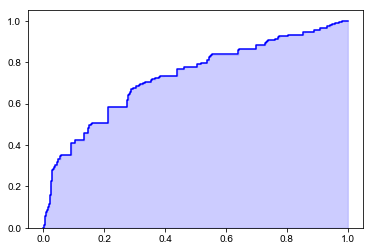

AUC=0.7376


In [76]:
# 4.4 RENN算法（下采样）

# 定义自变量，提取相关性系数大于±0.05的变量
threshold = 0.05
tmp = pdd_clean.corr()[['flag']].sort_values('flag', ascending=False)
var = tmp.where(np.abs(tmp)>threshold).dropna(how='any').index.values
var = var[1:]
X = pdd_clean[var]
y = pdd_clean['flag']

# RepeatedEditedNearestNeighbours算法
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
renn = RepeatedEditedNearestNeighbours(random_state = 100)
X_renn, y_renn = renn.fit_sample(X, y)

LR, X_train, X_test, y_train, y_test, y_pred = work(X_renn, y_renn, "RENN算法")



# 保存数据
names.append('+ RENN')
scores_train.append(LR.score(X_train, y_train))
scores_test.append(LR.score(X_test, y_test))
precisions.append(metrics.precision_score(y_test, y_pred)) #只看flag=1
recalls.append(metrics.recall_score(y_test, y_pred)) #只看flag=1
f1.append(metrics.f1_score(y_test, y_pred)) #只看flag=1
auc.append(metrics.auc(fpr, tpr))

NearMiss：


训练集打分：0.9575
测试集打分：0.9651
              precision    recall  f1-score   support

      flag=0       0.94      1.00      0.97       906
      flag=1       1.00      0.93      0.96       871

    accuracy                           0.97      1777
   macro avg       0.97      0.96      0.97      1777
weighted avg       0.97      0.97      0.97      1777



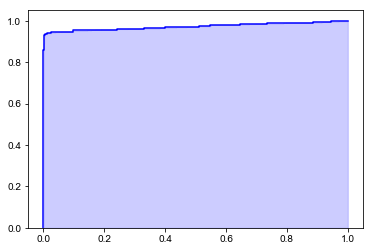

AUC=0.9725


In [77]:
# 4.5 NearMiss（下采样）

# 定义自变量，提取相关性系数大于±0.05的变量
threshold = 0.05
tmp = pdd_clean.corr()[['flag']].sort_values('flag', ascending=False)
var = tmp.where(np.abs(tmp)>threshold).dropna(how='any').index.values
var = var[1:]
X = pdd_clean[var]
y = pdd_clean['flag']

# NearMiss算法
from imblearn.under_sampling import NearMiss
nm1 = NearMiss(version=2) #选取正例样本中与N个最远邻负样本平均距离最短的样本
X_nm1, y_nm1 = nm1.fit_sample(X, y)

LR, X_train, X_test, y_train, y_test, y_pred = work(X_nm1, y_nm1, "NearMiss算法")

# 保存数据
names.append('+ NearMiss[v2]')
scores_train.append(LR.score(X_train, y_train))
scores_test.append(LR.score(X_test, y_test))
precisions.append(metrics.precision_score(y_test, y_pred)) #只看flag=1
recalls.append(metrics.recall_score(y_test, y_pred)) #只看flag=1
f1.append(metrics.f1_score(y_test, y_pred)) #只看flag=1
auc.append(metrics.auc(fpr, tpr))

SMOTEENN：


训练集打分：0.9306
测试集打分：0.9237
              precision    recall  f1-score   support

      flag=0       0.93      0.97      0.95      4564
      flag=1       0.88      0.72      0.79      1148

    accuracy                           0.92      5712
   macro avg       0.90      0.85      0.87      5712
weighted avg       0.92      0.92      0.92      5712



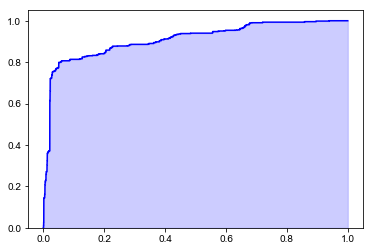

AUC=0.9101


In [78]:
# 4.6 SMOTEENN（组合算法）

# 定义自变量，提取相关性系数大于±0.05的变量
threshold = 0.05
tmp = pdd_clean.corr()[['flag']].sort_values('flag', ascending=False)
var = tmp.where(np.abs(tmp)>threshold).dropna(how='any').index.values
var = var[1:]
X = pdd_clean[var]
y = pdd_clean['flag']

# SMOTEENN算法
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state =100)
X_smote_enn, y_smote_enn = smote_enn.fit_sample(X, y)

LR, X_train, X_test, y_train, y_test, y_pred = work(X_smote_enn, y_smote_enn, "SMOTEENN算法")

# 保存数据
names.append('+ SMOTEENN')
scores_train.append(LR.score(X_train, y_train))
scores_test.append(LR.score(X_test, y_test))
precisions.append(metrics.precision_score(y_test, y_pred)) #只看flag=1
recalls.append(metrics.recall_score(y_test, y_pred)) #只看flag=1
f1.append(metrics.f1_score(y_test, y_pred)) #只看flag=1
auc.append(metrics.auc(fpr, tpr))

SMOTETomek：


训练集打分：0.6503
测试集打分：0.6519
              precision    recall  f1-score   support

      flag=0       0.65      0.68      0.66      6719
      flag=1       0.66      0.63      0.64      6693

    accuracy                           0.65     13412
   macro avg       0.65      0.65      0.65     13412
weighted avg       0.65      0.65      0.65     13412



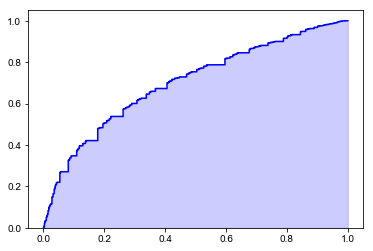

AUC=0.7071


In [79]:
# 4.7 SMOTETomek（组合算法）

# 定义自变量，提取相关性系数大于±0.05的变量
threshold = 0.05
tmp = pdd_clean.corr()[['flag']].sort_values('flag', ascending=False)
var = tmp.where(np.abs(tmp)>threshold).dropna(how='any').index.values
var = var[1:]
X = pdd_clean[var]
y = pdd_clean['flag']

# SMOTETomek
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state =100)
X_smote_tomek, y_smote_tomek = smote_tomek.fit_sample(X, y)

LR, X_train, X_test, y_train, y_test, y_pred = work(X_smote_tomek, y_smote_tomek, "SMOTETomek")

# 保存数据
names.append('+ SMOTETomek')
scores_train.append(LR.score(X_train, y_train))
scores_test.append(LR.score(X_test, y_test))
precisions.append(metrics.precision_score(y_test, y_pred)) #只看flag=1
recalls.append(metrics.recall_score(y_test, y_pred)) #只看flag=1
f1.append(metrics.f1_score(y_test, y_pred)) #只看flag=1
auc.append(metrics.auc(fpr, tpr))

- 对比选择NearMiss算法

NearMiss算法+改变损失函数的权重：


训练集打分：0.9575
测试集打分：0.9651
              precision    recall  f1-score   support

      flag=0       0.94      1.00      0.97       906
      flag=1       1.00      0.93      0.96       871

    accuracy                           0.97      1777
   macro avg       0.97      0.96      0.97      1777
weighted avg       0.97      0.97      0.97      1777



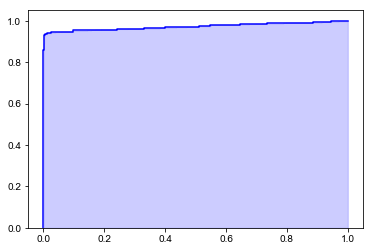

AUC=0.9725


In [80]:
# 5. NearMiss算法+改变损失函数的权重

# 定义自变量，提取相关性系数大于±0.05的变量
threshold = 0.05
tmp = pdd_clean.corr()[['flag']].sort_values('flag', ascending=False)
var = tmp.where(np.abs(tmp)>threshold).dropna(how='any').index.values
var = var[1:]
X = pdd_clean[var]
y = pdd_clean['flag']

# NearMiss算法
from imblearn.under_sampling import NearMiss
nm1 = NearMiss(version=2) #选取正例样本中与N个最远邻负样本平均距离最短的样本
X_nm1, y_nm1 = nm1.fit_sample(X, y)

LR, X_train, X_test, y_train, y_test, y_pred = work(X_nm1, y_nm1, "NearMiss算法+改变损失函数的权重")

# 保存数据
names.append('+ NearMiss[v2] + balanced')
scores_train.append(LR.score(X_train, y_train))
scores_test.append(LR.score(X_test, y_test))
precisions.append(metrics.precision_score(y_test, y_pred)) #只看flag=1
recalls.append(metrics.recall_score(y_test, y_pred)) #只看flag=1
f1.append(metrics.f1_score(y_test, y_pred)) #只看flag=1
auc.append(metrics.auc(fpr, tpr))

- 无变化，舍弃

NearMiss算法+改变损失函数的权重+改变正则化规则：


训练集打分：0.9575
测试集打分：0.9651
              precision    recall  f1-score   support

      flag=0       0.94      1.00      0.97       906
      flag=1       1.00      0.93      0.96       871

    accuracy                           0.97      1777
   macro avg       0.97      0.96      0.97      1777
weighted avg       0.97      0.97      0.97      1777



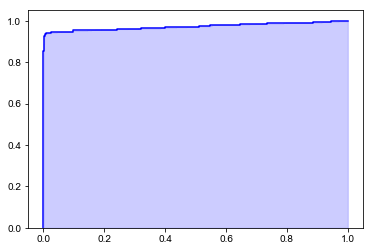

AUC=0.9725


In [81]:
# 6. NearMiss算法+改变损失函数的权重+改变正则化规则

# 定义自变量，提取相关性系数大于±0.05的变量
threshold = 0.05
tmp = pdd_clean.corr()[['flag']].sort_values('flag', ascending=False)
var = tmp.where(np.abs(tmp)>threshold).dropna(how='any').index.values
var = var[1:]
X = pdd_clean[var]
y = pdd_clean['flag']

# NearMiss算法
from imblearn.under_sampling import NearMiss
nm1 = NearMiss(version=2) #选取正例样本中与N个最远邻负样本平均距离最短的样本
X_nm1, y_nm1 = nm1.fit_sample(X, y)

LR, X_train, X_test, y_train, y_test, y_pred = work(X_nm1, y_nm1, "NearMiss算法+改变损失函数的权重+改变正则化规则")

# 保存数据
names.append('+ NearMiss[v2] + balanced + L1reg')
scores_train.append(LR.score(X_train, y_train))
scores_test.append(LR.score(X_test, y_test))
precisions.append(metrics.precision_score(y_test, y_pred)) #只看flag=1
recalls.append(metrics.recall_score(y_test, y_pred)) #只看flag=1
f1.append(metrics.f1_score(y_test, y_pred)) #只看flag=1
auc.append(metrics.auc(fpr, tpr))

- 无变化，舍弃

In [82]:
# 可视化所有方案并对比选择
data = pd.DataFrame({'plans' : names, 'scores_train' : scores_train, 'scores_test' : scores_test, 'precisions' : precisions, 'recalls' : recalls, 'f1-scores' : f1, 'AUC' : auc})

In [83]:
data

,plans,scores_train,scores_test,precisions,recalls,f1-scores,AUC
0,initial,0.880819,0.885466,0.418605,0.020857,0.039735,0.714068
1,+ test_size,0.883947,0.880164,0.383721,0.022044,0.041693,0.714068
2,+ X1,0.880819,0.885466,0.418605,0.020857,0.039735,0.714068
3,+ X2,0.880876,0.885466,0.418605,0.020857,0.039735,0.714068
4,+ standalization,0.881271,0.885861,0.454545,0.023175,0.044101,0.714068
5,+ SMOTE,0.647070,0.658267,0.668929,0.630335,0.649058,0.714068
6,+ RandomOverSampler,0.648732,0.650067,0.659595,0.624089,0.641351,0.714068
7,+ RandomUnderSampler,0.649457,0.631964,0.622047,0.634902,0.628409,0.714068
8,+ RENN,0.847541,0.841781,0.538462,0.114880,0.189360,0.714068
9,+ NearMiss[v2],0.957539,0.965110,0.995104,0.933410,0.963270,0.714068


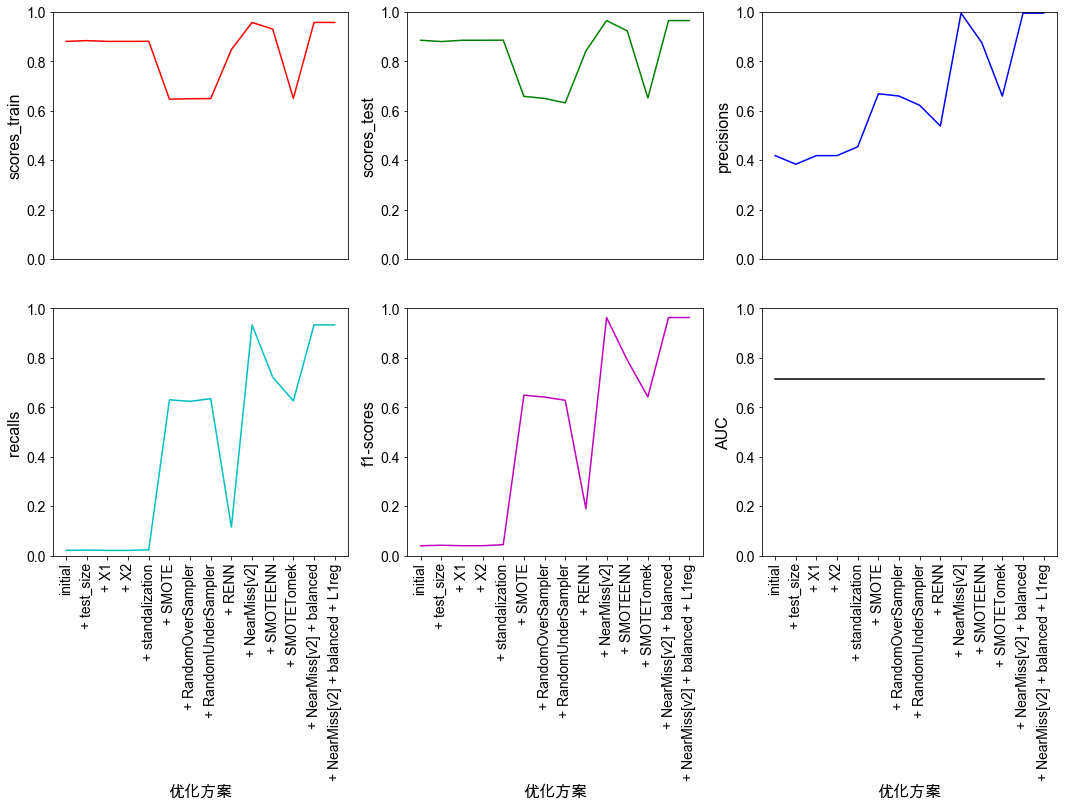

In [84]:
plt.figure(figsize=(18,10))
colors = ['r', 'g', 'b', 'c', 'm', 'k']
labels = data.columns.values

for i in range(0, 6):
    plt.subplot(2,3,i+1)
    plt.plot(data[labels[0]], data[labels[i+1]], colors[i])
    plt.ylim(0,1) 
    plt.tick_params(labelsize=14)
    plt.ylabel(labels[i+1], size=16)
    if i<3:
        plt.xticks([])
    else:
        plt.xticks(rotation=90)
        plt.xlabel('优化方案', size=16)

- pick NearMiss(v2)算法方案

In [85]:
# 优化后模型参数解读


# 定义自变量，提取相关性系数大于±0.05的变量
threshold = 0.05
tmp = pdd_clean.corr()[['flag']].sort_values('flag', ascending=False)
var = tmp.where(np.abs(tmp)>threshold).dropna(how='any').index.values
var = var[1:]
X = pdd_clean[var]
y = pdd_clean['flag']

# NearMiss算法
from imblearn.under_sampling import NearMiss
nm1 = NearMiss(version=2) #选取正例样本中与N个最远邻负样本平均距离最短的样本
X_nm1, y_nm1 = nm1.fit_sample(X, y)

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X_nm1, y_nm1, test_size = 0.3, random_state = 100)

# 训练模型
LR = LogisticRegression()
LR.fit(X_train, y_train)

# 模型参数
for a, b in zip(np.append(var, 'intercept'), np.append(LR.coef_, LR.intercept_)):
    print("参数 %s : %.3f  概率比值 %.3f" % (a, b, np.exp(b)))



参数 age_range_>65 : 1.464  概率比值 4.325
参数 coupon_used_in_last_month : 0.314  概率比值 1.369
参数 job_retired : -0.061  概率比值 0.941
参数 job_student : 0.269  概率比值 1.309
参数 marital_single : 0.042  概率比值 1.043
参数 marital_married : -0.308  概率比值 0.735
参数 loan_yes : -0.340  概率比值 0.712
参数 job_blue-collar : -0.132  概率比值 0.877
参数 coupon_used_in_last6_month : -1.242  概率比值 0.289
参数 returned_yes : -0.547  概率比值 0.578
参数 intercept : 5.802  概率比值 330.947
